In [195]:
%matplotlib inline
import diogenes.read as read
import diogenes.display as display
import diogenes.modify as modify
import diogenes.utils as utils
import numpy as np

### Methods

1. Data obtained from the [Citizens Police Data Project](cpdb.co).
2. This data includes only the FOIA dataset from 2011 to present (i.e. the Bond and Moore datasets have been removed). 
3. This was accomplished by entering FOIA in the search bar.
4. The resulting table was saved locally as a .xslx.
5. The Allegations, Complaining Witnesses, and Officer Profile tabs were then saved locally as allegations.csv, citizens.csv, and officers.csv respectively.


### Disclaimer

The following disclaimer is included with the data by the [Invisible Institute](http://invisible.institute).


This dataset is compiled from three lists of allegations against Chicago Police Department officers,
spanning approximately 2002 - 2008 and 2010 - 2014, produced by the City of Chicago in response
to litigation and to FOIA requests.

The City of Chicago's production of this information is accompanied by a disclaimer that
not all information contained in the City's database may be correct.

No independent verification of the City's records has taken place and this dataset does not
purport to be an accurate reflection of either the City's database or its veracity.

In [290]:
#Record arrays
allegations = read.open_csv('allegations.csv',parse_datetimes=['IncidentDate','StartDate','EndDate'])
citizens = read.open_csv('citizens.csv')
officers = read.open_csv('officers.csv')

### What data do we have?

We can see the column names for the three tables below.

1. The Allegations table includes data on each allegation, including an ID for the complaint witness, the officer, and the outcome of the allegation. 
2. The Citizens table includes additional information for each complaint witness.
3. The Officers table includes additional information for each officer.

In [291]:
print allegations.dtype.names,'\n'
print citizens.dtype.names,'\n'
print officers.dtype.names,'\n'

('CRID', 'OfficerID', 'OfficeFirst', 'OfficerLast', 'AllegationCode', 'Category', 'Allegation', 'RecommendedFinding', 'RecommendedOutcome', 'FinalFinding', 'FinalOutcome', 'Finding', 'Outcome', 'Beat', 'Location', 'Add1', 'Add2', 'City', 'IncidentDate', 'StartDate', 'EndDate', 'Investigator') 

('CRID', 'Gender', 'Race') 

('OfficerID', 'OfficerFirst', 'OfficerLast', 'Gender', 'Race', 'ApptDate', 'Unit', 'Rank', 'Star') 



For this analysis, we will be removing several columns for the following reasons:

1. To anonymize our data, names of officers and investiagtors have been removed.
2. Many of the columns in Allegations are redundant as they code for other columns. We will preserve only the human readable columns.
3. The Beat column has no data, so it will be removed.
4. We will only focus on final outcomes, so the "recommended" columns have been removed.
5. We will be limiting our geographic analysis to Location, so the address information has been removed.

In [292]:
#TODO: there is a typo in the "OfficerFirst" column in allegations.
#Should pass this on to Kalven at Invisible Institute along with questions about data.
allegations = utils.remove_cols(allegations,['OfficeFirst','OfficerLast','Investigator','AllegationCode','RecommendedFinding','RecommendedOutcome','FinalFinding','FinalOutcome','Beat','Add1','Add2','City'])
officers = utils.remove_cols(officers,['OfficerFirst','OfficerLast'])

For ease of use, let's join our tables.

In [293]:
master = utils.join(allegations,citizens,'left',['CRID'],['CRID'])

#Rename Race and Gender, since citizens and officers have these columns
temp_col_names = list(master.dtype.names)
gender_index = temp_col_names.index("Gender")
race_index = temp_col_names.index("Race")
temp_col_names[gender_index] = "CitizenGender"
temp_col_names[race_index] = "CitizenRace"
master.dtype.names = tuple(temp_col_names)

master = utils.join(master,officers,'left',['OfficerID'],['OfficerID'])
temp_col_names = list(master.dtype.names)
gender_index = temp_col_names.index("Gender")
race_index = temp_col_names.index("Race")
temp_col_names[gender_index] = "OfficerGender"
temp_col_names[race_index] = "OfficerRace"
master.dtype.names = tuple(temp_col_names)

Now, let's encode these numerically

In [322]:
master_data, master_classes = modify.label_encode(master)

For convenience, we'll build every possible categorical directive

In [325]:
#Directives

def cat_directives(array,classes):
    cat_directives = {}
    for column in classes:
        cat_directives[column] = {v:[{'func': modify.row_val_eq, 'col_name': column, 'vals': i}] for i,v in enumerate(classes[column])}
    return cat_directives

where = cat_directives(master_data,master_classes)

Now, we can build intuitive masks as combinations of our human-readable directives

In [326]:
#Masks

#Gender
female_officers = modify.where_all_are_true(master_data,where['OfficerGender']['F'])
male_officers = modify.where_all_are_true(master_data,where['OfficerGender']['M'])

female_citizens = modify.where_all_are_true(master_data,where['CitizenGender']['F'])
male_citizens = modify.where_all_are_true(master_data,where['CitizenGender']['M'])

#Race
white_officers = modify.where_all_are_true(master_data,where['OfficerRace']['White'])
black_officers = modify.where_all_are_true(master_data,where['OfficerRace']['Black'])
hispanic_officers = modify.where_all_are_true(master_data,where['OfficerRace']['Hispanic'])

white_citizens = modify.where_all_are_true(master_data,where['CitizenRace']['White'])
black_citizens = modify.where_all_are_true(master_data,where['CitizenRace']['Black'])
hispanic_citizens = modify.where_all_are_true(master_data,where['CitizenRace']['Hispanic'])

#Cross-sections
white_M_officers_black_F_citizens = modify.where_all_are_true(master_data,where['OfficerRace']['White']+
                                                                     where['OfficerGender']['M']+
                                                                     where['CitizenRace']['Black']+
                                                                     where['CitizenGender']['F'])


We understand what data we have, and we have some tools to easily slice and dice. Let's dive in and learn something.

0.0836069539972


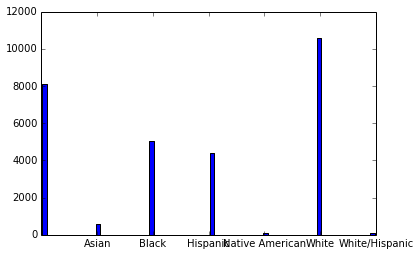

In [336]:
#This seems a little clunky to me
#Would be nice if plot_simple_histogram could handle categorical labels for me
display.plot_simple_histogram(master_data['OfficerRace'],verbose=False)
display.plt.xticks(range(len(master_classes['OfficerRace'])), master_classes['OfficerRace'])

#Ex: What percentage of allegations have a black female citizen and a white male officer?
print np.sum(white_M_officers_black_F_citizens.astype(np.float))/np.size(white_M_officers_black_F_citizens.astype(np.float))

In [287]:
temp = np.subtract(master["EndDate"],master["StartDate"])
master


print master["CRID"][0]
print master["EndDate"][0]
print master["StartDate"][0]
print temp/10**9/60/60/24

1057642
2013-05-15T19:00:00.000000000-0500
2012-10-08T19:00:00.000000000-0500
[219  46 361 ..., 155  25 461]
